In [1]:
import pandas as pd
import numpy as np

In [2]:
from qiime2 import Artifact

In [3]:
from skbio.stats import subsample_counts
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from skbio import OrdinationResults, DistanceMatrix

from scipy.stats import mannwhitneyu

In [4]:
from itertools import combinations

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

In [6]:
%matplotlib inline
sns.set(style='white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
plt.rcParams['lines.markersize'] = 15

# PCOA plot function

In [7]:
def pcoa_plot(dist_mtx, metadata, column=None, title='', do_permanova=True, hue_order=None, **kwargs):
    print(f'Matrix={len(dist_mtx.ids)}, MD={len(metadata.index)}, column={column}')
    pc = pcoa(dist_mtx)
    if do_permanova:
        perm = permanova(dist_mtx, metadata, column)
    if hue_order:
        if column:
            used_hues = set(metadata[column].unique())
        else:
            used_hues = set(metadata.index)
        hue_order = [c for c in hue_order if c in used_hues]
    pc_df = pc.samples.join(metadata, how='inner')
    if column is None:
        pc_df = pc_df.reset_index()
        column = pc_df.columns[0]

    if do_permanova:
        pc1_a = pc_df[pc_df.condition == hue_order[0]].PC1.to_numpy()
        pc1_b = pc_df[pc_df.condition == hue_order[1]].PC1.to_numpy()
        pc1_mw = mannwhitneyu(pc1_a, pc1_b)
 
        pc2_a = pc_df[pc_df.condition == hue_order[0]].PC2.to_numpy()
        pc2_b = pc_df[pc_df.condition == hue_order[1]].PC2.to_numpy()
        pc2_mw = mannwhitneyu(pc2_a, pc2_b)
    
    
    scatter_args = {
        'data': pc_df,
        'x':    'PC1',
        'y':    'PC2',
        'hue':  column,
    }
    scatter_args.update(kwargs)
    if hue_order:
        scatter_args['hue_order'] = hue_order

    # make sure the boxplots have enough room on the left and bottom margins
    num_hues = len(pc_df[column].unique())
    minor = 0.06 * num_hues
    major = 1 - minor
    fig, axes = plt.subplots(
        nrows=2, ncols=2, 
        width_ratios=(minor,major), 
        height_ratios=(major,minor), 
        figsize=(8,8),
    )

    # main scatterplot
    sns.scatterplot(**scatter_args, ax=axes[0][1])
    axes[0][1].set(
        xlabel=None,
        xticklabels=[],
        ylabel=None,
        yticklabels=[],
    )
    plt.legend(bbox_to_anchor=(1.05, 1))

    # stats
    if do_permanova:
        xlabel = f'PC1({pc.proportion_explained[0]:.2%}), p={pc1_mw.pvalue:.3f}'
        ylabel = f'PC2({pc.proportion_explained[1]:.2%}), p={pc2_mw.pvalue:.3f}'
    else:
        xlabel = f'PC1({pc.proportion_explained[0]:.2%})'
        ylabel = f'PC2({pc.proportion_explained[1]:.2%})'

    
    # PC1 boxplot
    pc1_args = scatter_args.copy()
    pc1_args['y'] = scatter_args['hue']
    sns.boxplot(**pc1_args, ax=axes[1][1])
    axes[1][1].set(
        ylabel=None,
        yticklabels=[],
        xlabel=xlabel,
    )
    axes[1][1].get_legend().remove()
    # PC2 boxplot
    pc2_args = scatter_args.copy()
    pc2_args['x'] = scatter_args['hue']
    sns.boxplot(**pc2_args, ax=axes[0][0])
    axes[0][0].set(
        xlabel=None,
        xticklabels=[],
        ylabel=ylabel,
    )
    axes[0][0].get_legend().remove()
    axes[1][0].set_axis_off()
    if do_permanova:
        plt.suptitle(f'{title} [Permanova p={perm["p-value"]}]')
    else:
        plt.suptitle(title)
    plt.tight_layout()
    return fig, pc_df

# load metadata

In [8]:
md = pd.read_csv('cohort1.metadata.tsv', sep='\t', index_col=0)
sorted(list(md.columns))

['barcode_id',
 'cage_id',
 'collection_date',
 'collection_time',
 'collection_timestamp',
 'collection_timestamp_24',
 'collection_timestamp_zt',
 'condition',
 'country',
 'description',
 'dna_extracted',
 'dob',
 'elevation',
 'empo_1',
 'empo_2',
 'empo_3',
 'empo_4',
 'env_biome',
 'env_feature',
 'env_material',
 'env_package',
 'geo_loc_name',
 'host_age',
 'host_age_units',
 'host_collection_age',
 'host_collection_age_units',
 'host_common_name',
 'host_life_stage',
 'host_scientific_name',
 'host_subject_id',
 'host_taxid',
 'host_weight',
 'host_weight_units',
 'iacuc_institute',
 'iacuc_protocol_id',
 'latitude',
 'life_stage',
 'longitude',
 'physical_specimen_location',
 'physical_specimen_remaining',
 'qiita_sample_type',
 'qiita_study_id',
 'replicate_sample',
 'sample_type',
 'scientific_name',
 'sex',
 'taxon_id',
 'title',
 'tube_id']

In [9]:
condition_order = [
    'BSH- VEHICLE',
    'BSH+ VEHICLE',
    'BSH- LETROZOLE',
    'BSH+ LETROZOLE',
]
condition_groups = list(
    combinations(condition_order,2)
)
condition_palette = {
    'BSH- VEHICLE': 'blue',
    'BSH+ VEHICLE': 'green',
    'BSH- LETROZOLE': 'orange',
    'BSH+ LETROZOLE': 'red',
}

# Genome counts

In [10]:
beta_div = Artifact.load('merged.core_metrics/bray_curtis_distance_matrix.qza').view(DistanceMatrix)

# Plots

Matrix=20, MD=20, column=condition


/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.023895828877938848 and the largest is 1.1949492759887075.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


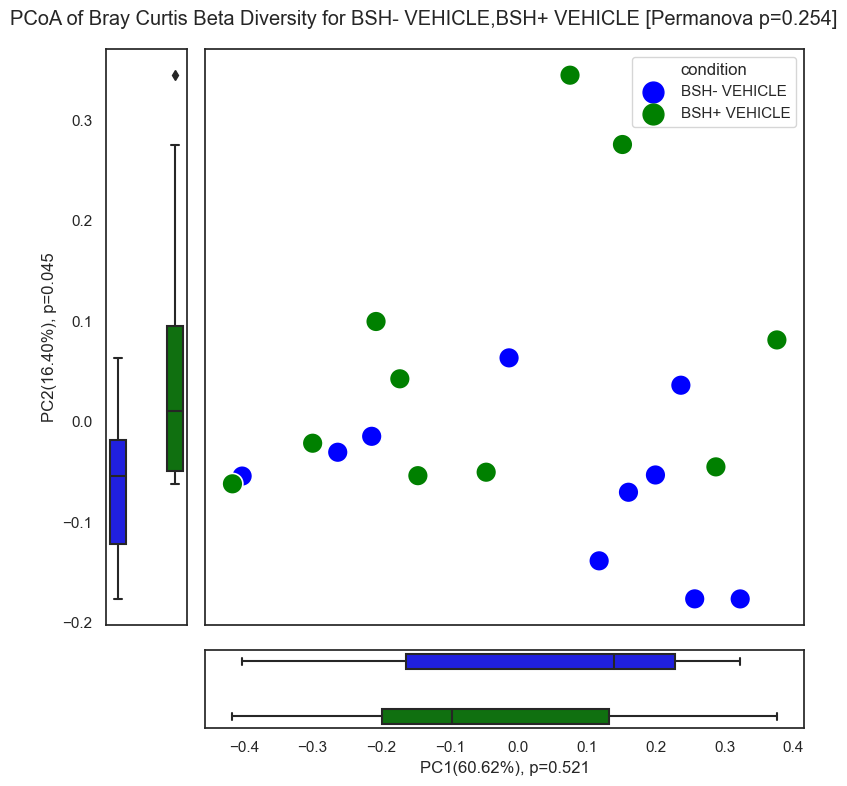

/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03636305400147037 and the largest is 1.2499286869554624.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matrix=20, MD=20, column=condition


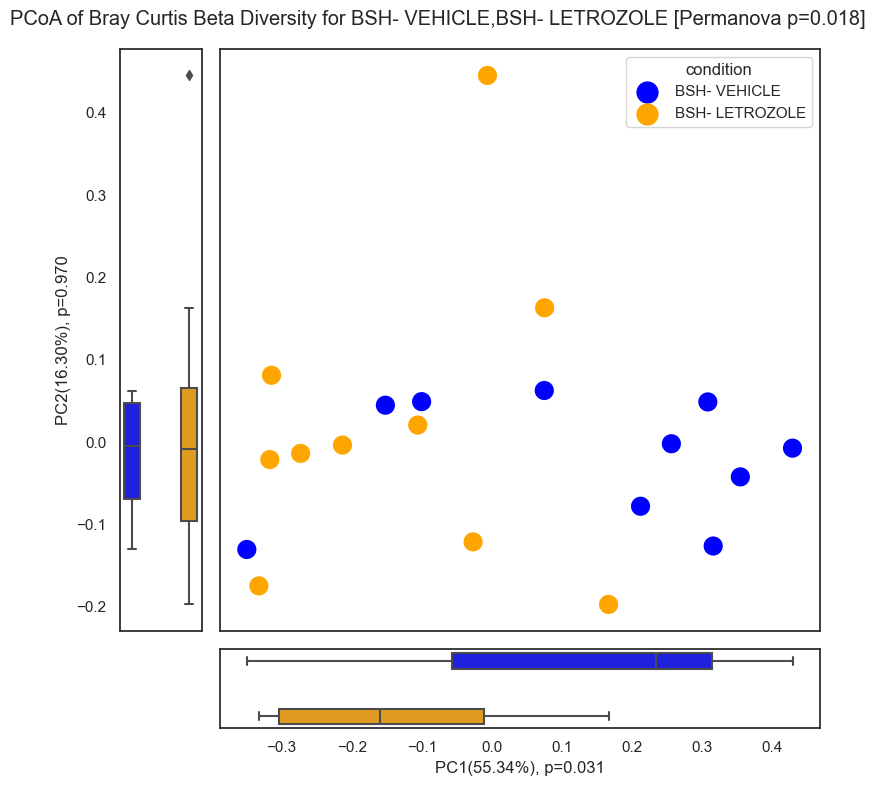

/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.020420407489364998 and the largest is 1.5286584306222504.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matrix=20, MD=20, column=condition


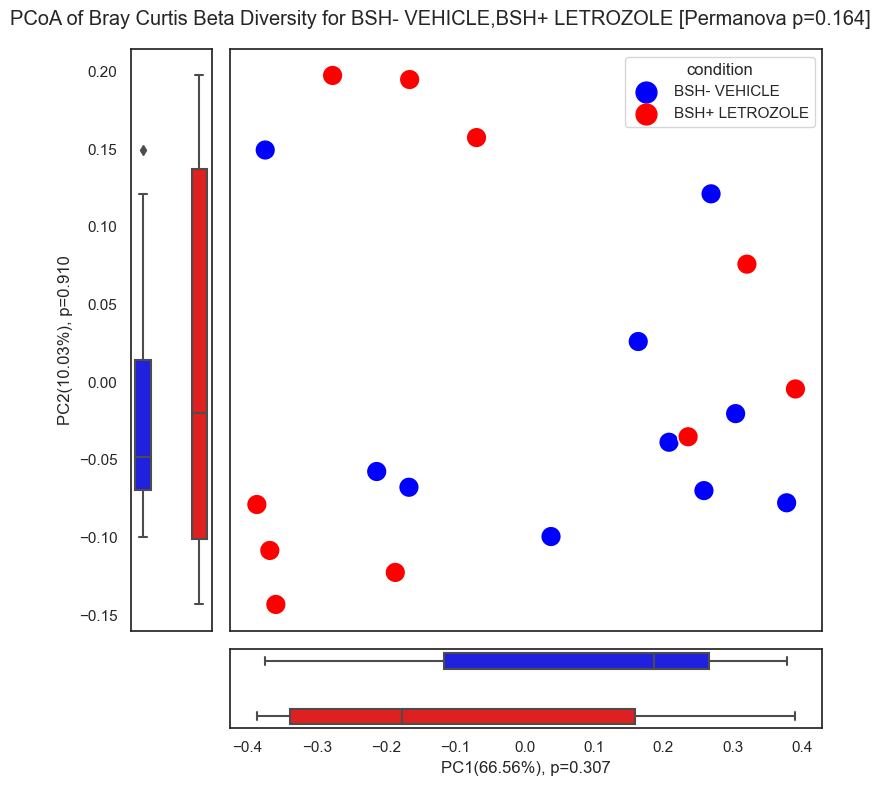

/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06112382533690501 and the largest is 1.1045684667421922.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matrix=20, MD=20, column=condition


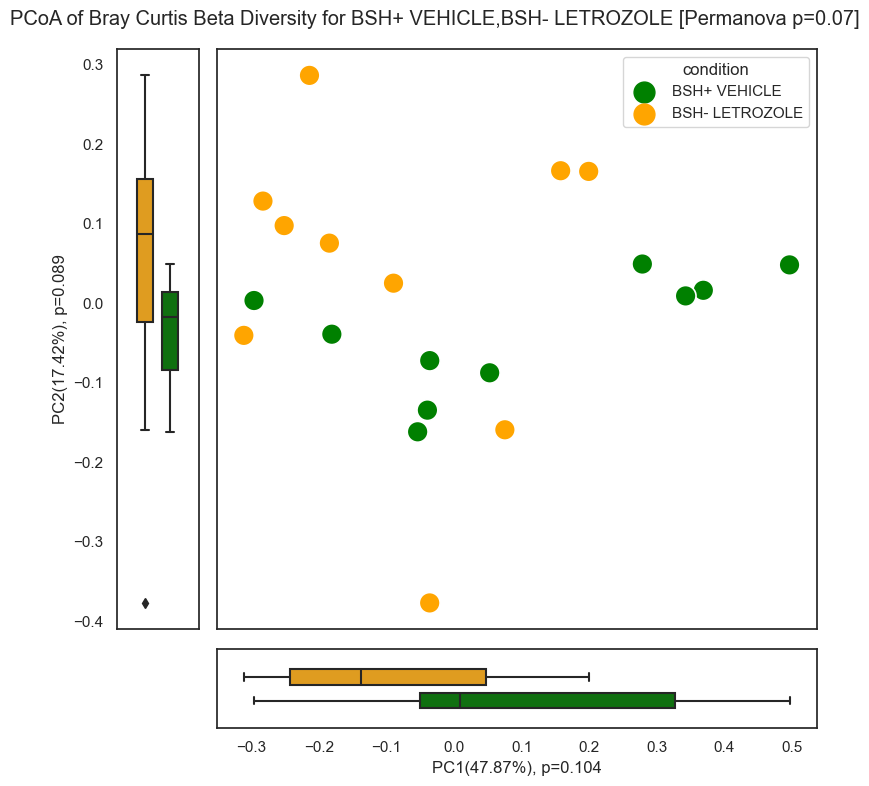

/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03855103590940773 and the largest is 1.4669707536533863.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matrix=20, MD=20, column=condition


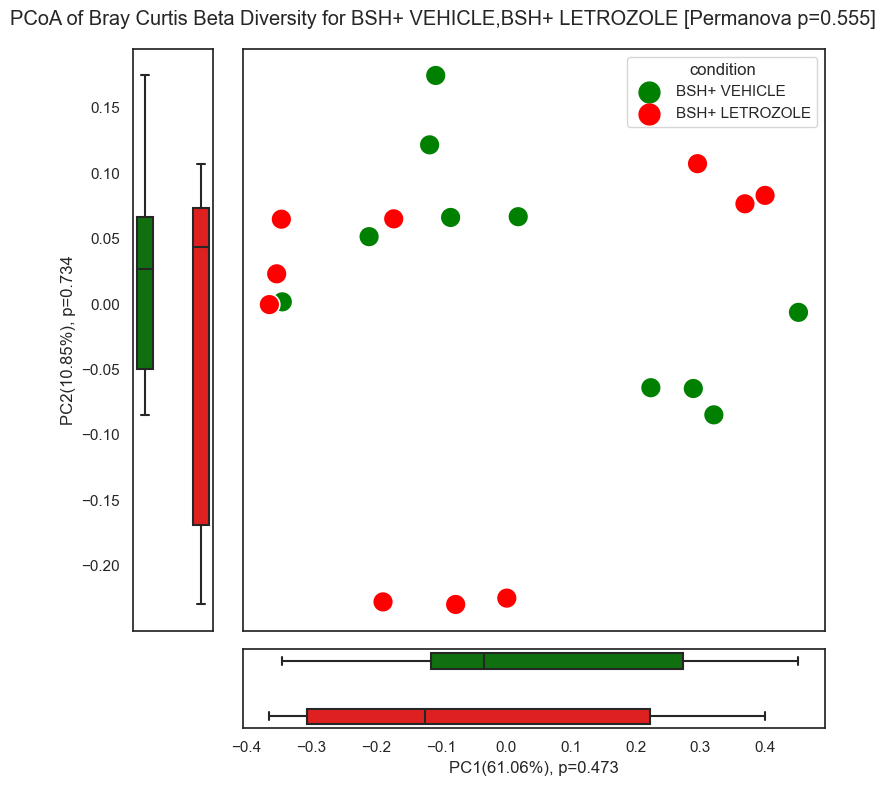

Matrix=20, MD=20, column=condition


/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03750258437369559 and the largest is 1.160207720214012.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


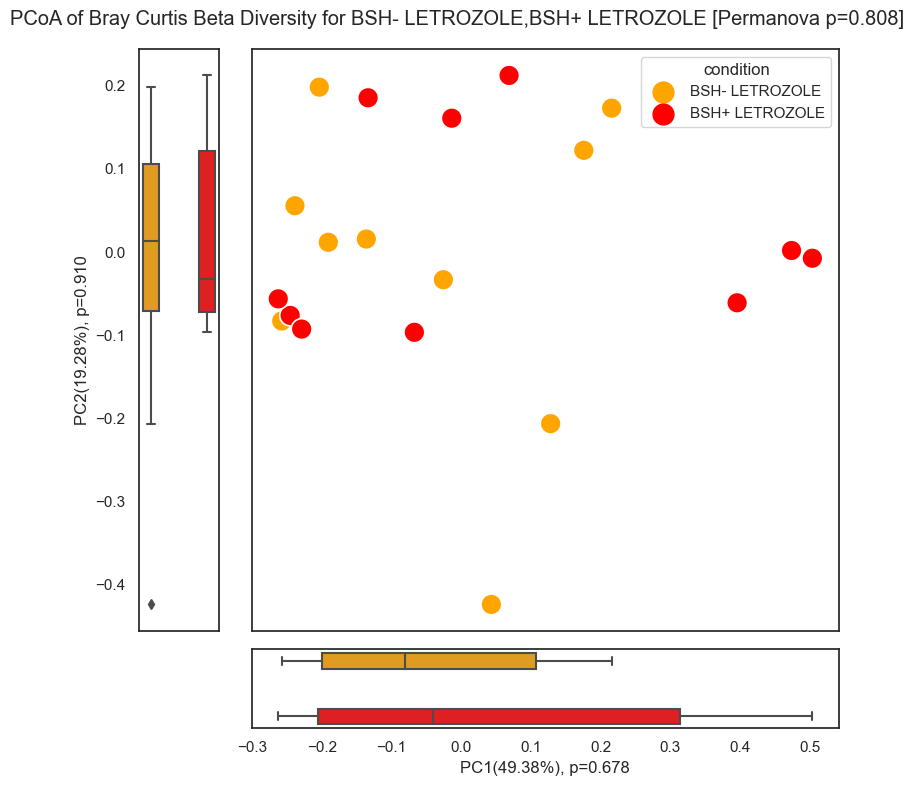

/mnt/zarrinpar/Pynchon/opt/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.10457971300294117 and the largest is 2.603475643213152.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matrix=40, MD=40, column=condition


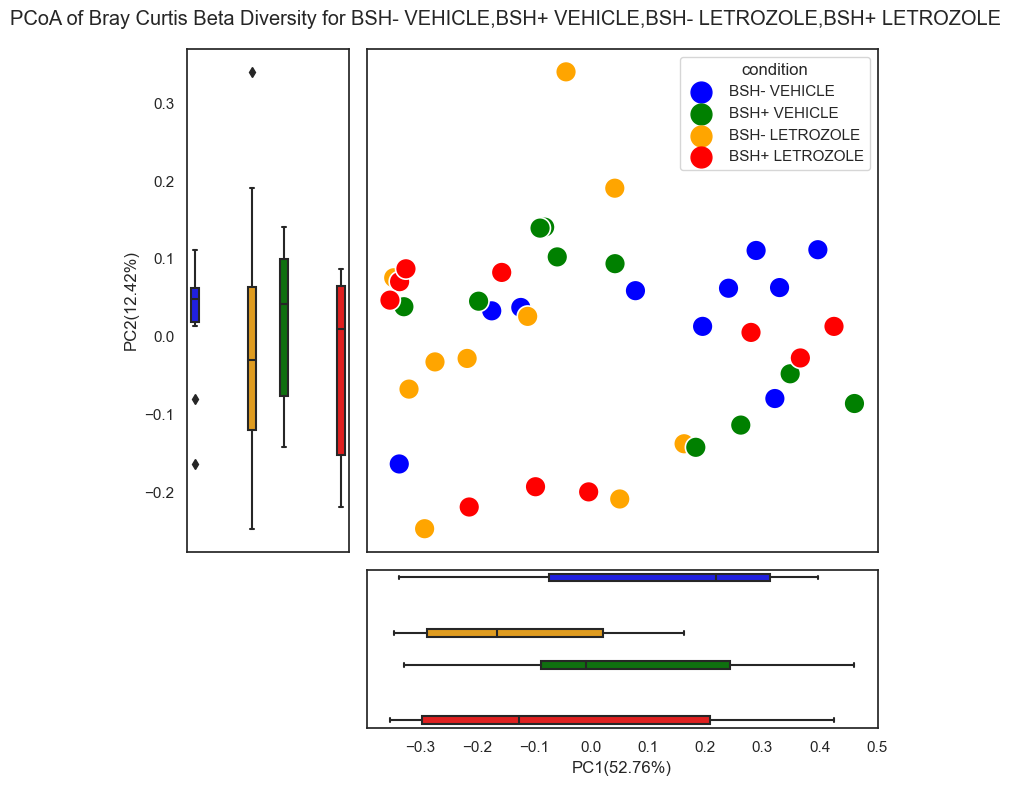

In [11]:
for g in condition_groups + [condition_order]:
    sub_md = md[md.condition.isin(g)]
    sub_dist = beta_div.filter(sub_md.index)
    do_perm = len(g)==2
    sub_order = [c for c in condition_order if c in sub_md.condition.unique()]
    fig, pc_df = pcoa_plot(
        sub_dist, 
        sub_md, 
        'condition',
        do_permanova=do_perm,
        hue_order=sub_order,
        palette=condition_palette,
        title=f"PCoA of Bray Curtis Beta Diversity for {','.join(g)}",
    )
    plt.savefig(f'images/beta.bray_curtis_pcoa.{".".join(g)}.svg')
    plt.show()

In [14]:
pc_df.iloc[0].index

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37',
       'PC38', 'PC39', 'PC40', 'barcode_id', 'cage_id', 'collection_date',
       'collection_time', 'collection_timestamp', 'collection_timestamp_24',
       'collection_timestamp_zt', 'condition', 'country', 'description',
       'dna_extracted', 'dob', 'elevation', 'empo_1', 'empo_2', 'empo_3',
       'empo_4', 'env_biome', 'env_feature', 'env_material', 'env_package',
       'geo_loc_name', 'host_age', 'host_age_units', 'host_collection_age',
       'host_collection_age_units', 'host_common_name', 'host_life_stage',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'host_weight',
       'host_weight_units', 'iacuc_institute', 'iacuc_protocol_id', 'latitude',


In [15]:
pc_df.condition.value_counts()

BSH- VEHICLE      10
BSH- LETROZOLE    10
BSH+ VEHICLE      10
BSH+ LETROZOLE    10
Name: condition, dtype: int64

In [17]:
per_cond_pc1 = {}
per_cond_pc2 = {}
for cond in pc_df.condition.unique():
    per_cond_pc1[cond] = pc_df[pc_df.condition == cond].PC1.to_numpy()
    per_cond_pc2[cond] = pc_df[pc_df.condition == cond].PC2.to_numpy()

In [20]:
from itertools import combinations
pairs = tuple(combinations(pc_df.condition.unique(), 2))
for l,r in pairs:
    pc1_mw = mannwhitneyu(per_cond_pc1[l], per_cond_pc1[r])
    pc2_mw = mannwhitneyu(per_cond_pc2[l], per_cond_pc2[r])
    print(f'{l} vs {r} Mann Whitney --  PC1: p={pc1_mw.pvalue:.3f}, PC2: p={pc2_mw.pvalue:.3f}')

BSH- VEHICLE vs BSH- LETROZOLE Mann Whitney --  PC1: p=0.026, PC2: p=0.385
BSH- VEHICLE vs BSH+ VEHICLE Mann Whitney --  PC1: p=0.623, PC2: p=0.970
BSH- VEHICLE vs BSH+ LETROZOLE Mann Whitney --  PC1: p=0.307, PC2: p=0.273
BSH- LETROZOLE vs BSH+ VEHICLE Mann Whitney --  PC1: p=0.104, PC2: p=0.571
BSH- LETROZOLE vs BSH+ LETROZOLE Mann Whitney --  PC1: p=0.734, PC2: p=0.850
BSH+ VEHICLE vs BSH+ LETROZOLE Mann Whitney --  PC1: p=0.345, PC2: p=0.307
